# Numerically Controlled Oscillator

In this tutorial we will demonstrate how to use the numerically controlled oscillator (NCO) during an experiment by:
1. [Changing the modulation frequency](#Frequency-sweeps), e.g. for rapid spectroscopy measurements
2. [Setting the phase](#Phase-updates), e.g. for virtual $Z$ gates

This tutorial has multiple sections showcasing how the hardware behaves in certain edge cases. These are optional and can be skipped.

We will show this by using a QRM and directly connecting outputs 
$\text{O}^{[1-2]}$ to inputs $\text{I}^{[1-2]}$ respectively. We will then use the QRM's sequencers to sequence waveforms on 
the outputs and simultaneously acquire the resulting waveforms on the inputs.

To run this tutorial please make sure you have installed and enabled ipywidgets: 
```
pip install ipywidgets
jupyter nbextension enable -–py widgetsnbextension
```
## Getting Started
### How the NCO works
#### Modulation
The NCO modulates any AWG output at a certain frequency, such that we only need to store the envelope of any waveform to create a wave with the correct frequency and phase. To enable IQ up- and downconversion to RF frequencies, the device will generate a phase shifted signal on both signal paths. If modulation is enabled, the value of the NCO will be multiplied with the awg output and forwarded to path 0/1 as follows:

\begin{equation*}
\text{path}_{0, \text{out}} = \frac{1}{\sqrt{2}}(\cos(\omega t)\text{awg}_0+\sin(\omega t)\text{awg}_1)
\tag{1}
\end{equation*}

\begin{equation*}
\text{path}_{1, \text{out}} = \frac{1}{\sqrt{2}}(-\sin(\omega t)\text{awg}_0+\cos(\omega t)\text{awg}_1)
\tag{2}
\end{equation*}

Note the factor $\sqrt{2}$, which is required to preserve the total signal amplitude and prevents clipping. These two outputs can then be used within a QRM-RF module or by an external mixer to generate RF pulses.

#### Demodulation
Usually, we are interested in the envelope of the acquired signal instead of the oscillating values, in particular when integrating. Therefore, the NCO can also be used to demodulate the signal before integration.
If demodulation is enabled, the signal is again multiplied with the NCO, this time with a prefactor $\sqrt{2}$. Thus, if we modulate and demodulate the same signal, we obtain the original awg output:

\begin{equation*}
\text{path}_{0, \text{in}} = \sqrt{2}(\cos(\omega t)\text{in}_0-\sin(\omega t)\text{in}_1)
=  \cos(\omega t)\cos(\omega t)\text{awg}_0+\sin(\omega t)\sin(\omega t)\text{awg}_0 = \text{awg}_0
\tag{3}
\end{equation*}

\begin{equation*}
\text{path}_{1, \text{in}} = \sqrt{2}(\cos(\omega t)\text{in}_1+\sin(\omega t)\text{in}_0)
=  \cos(\omega t)\cos(\omega t)\text{awg}_1+\sin(\omega t)\sin(\omega t)\text{awg}_1 = \text{awg}_1
\tag{4}
\end{equation*}



### Setup

First, we are going to import the required packages and connect to the instrument.

In [1]:
# Import ipython widgets
import json

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

# Set up the environment.
from IPython.display import display
from scipy.signal import spectrogram, welch, gaussian

from qblox_instruments import Cluster, PlugAndPlay, Pulsar

#### Scan For Devices

We scan for the available devices connected via ethernet using the [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/api_reference/pnp.html) functionality of the Qblox Instruments package.

In [2]:
# Scan for available devices and display
with PlugAndPlay() as p:
    # get info of all devices
    device_list = p.list_devices()
    device_keys = list(device_list.keys())

# create widget for names and ip addresses
connect = widgets.Dropdown(
    options=[(device_list[key]["description"]["name"]) for key in device_list.keys()],
    description="Select Device",
)
display(connect)
device_name = connect.value

Dropdown(description='Select Device', options=('cluster-mm',), value='cluster-mm')

#### Pulsar QRM <a id='pulsar_setup'></a>
If you chose the Pulsar QRM, run the following cell. Skip to the [Cluster QRM section](#cluster_setup) if you selected a Cluster module.

In [ ]:
# Close existing connections to the Pulsar modules
Pulsar.close_all()

# Retrieve device name and IP address
device_name = connect.value
device_number = connect.options.index(device_name)
ip_address = device_list[device_keys[device_number]]["identity"]["ip"]

# Connect to device and reset
qrm = Pulsar(f"{device_name}", ip_address)
qrm.reset()
cluster = None  # In absence of a cluster
print(f"{device_name} connected at {ip_address}")
print(qrm.get_system_state())

Skip to the next section [Frequency sweeps](#freq_sw) if you are not using a cluster. 

#### Cluster QRM <a id='cluster_setup'></a>
First we connect to the Cluster using its IP address. Go to the [Pulsar QRM section](#pulsar_setup) if you are using a Pulsar.


In [3]:
# close all previous connections to the cluster
Cluster.close_all()

# Retrieve device name and IP address
device_name = connect.value
device_number = connect.options.index(device_name)
ip_address = device_list[device_keys[device_number]]["identity"]["ip"]

# connect to the cluster and reset
cluster = Cluster(device_name, ip_address)
cluster.reset()
print(f"{device_name} connected at {ip_address}")

cluster-mm connected at 192.168.0.2


We then find all available cluster modules to connect to them individually.

In [4]:
# Find all QRM/QCM modules
available_slots = {}
for module in cluster.modules:
    # if module is currently present in stack
    if cluster._get_modules_present(module.slot_idx):
        # check if QxM is RF or baseband
        if module.is_rf_type:
            available_slots[f"module{module.slot_idx}"] = ["QCM-RF", "QRM-RF"][
                module.is_qrm_type
            ]
        else:
            available_slots[f"module{module.slot_idx}"] = ["QCM", "QRM"][
                module.is_qrm_type
            ]

# List of all QxM modules present
connect_qxm = widgets.Dropdown(options=[key for key in available_slots.keys()])

print(available_slots)
# display widget with cluster modules
print()
print("Select the QRM module from the available modules in your Cluster:")
display(connect_qxm)

{'module8': 'QRM', 'module11': 'QRM-RF'}

Select the QRM module from the available modules in your Cluster:


Dropdown(options=('module8', 'module11'), value='module8')

Finally, we connect to the selected Cluster module. 

In [5]:
# Connect to the cluster QRM
qrm = getattr(
    cluster, connect_qxm.value
)  # Connect to the module that you have chosen above
print(f"{available_slots[connect_qxm.value]} connected")
print(cluster.get_system_state())

QRM connected
Status: OKAY, Flags: NONE, Slot flags: NONE


Frequency sweeps  <a id='freq_sw'></a>
------------------------------
One of the most common experiments is to test the frequency response of the system, e.g. to find the resonance frequencies of a qubit or a resonator. For the purpose of this tutorial, we will sweep the full frequency range supported by the QRM. To improve accuracy we can use the maximum integration time and multiple averages. This does not change the overall measurement time much, as most of it is used for the setup.

In [6]:
start_freq = -500e6
stop_freq = 500e6

n_averages = 10
MAXIMUM_SCOPE_ACQUISITION_LENGTH  = 16384

In this tutorial, we will analyze the raw data measured by the scope acquisition of the QRM. For this we will define a simple helper function using [scipy.signal.spectrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html) and [scipy.signal.welch](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html). The spectrogram shows the frequency spectrum of the QRM output as a function of time, to visualize the frequency sweeps we are doing. Welch's method is used to compute the input power as a function of frequency (power spectral density). This way we obtain the response of the system to find features of interest, e.g. a resonance.

In [7]:
# Power as function of frequency and time by chunking the data
def plot_spectrogram(time_series: np.ndarray) -> None:
    f_sample = 1e9  # All devices have 1 GSPS sample rate
    fig, ax = plt.subplots(1, 2)

    f, t, Sxx = spectrogram(time_series, f_sample, return_onesided=False, detrend=False)
    
    idx = np.argsort(f)
    f = f[idx] / 1e6
    Sxx = Sxx[idx]
    
    spec = ax[0].pcolormesh(t, f, Sxx, shading="auto", cmap="YlOrRd")
    cb = fig.colorbar(spec)
    cb.set_label("Power Spectral Density [V$^2$/Hz]")
    ax[0].set_ylabel("Frequency [MHz]")
    ax[0].set_xlabel("Time [s]")

    f, Pxx = welch(time_series, f_sample, return_onesided=False, detrend=False)
    
    idx = np.argsort(f)
    f = f[idx] / 1e6
    Pxx = Pxx[idx]
    
    ax[1].semilogy(f, Pxx)
    ax[1].set_xlabel("Frequency [MHz]")
    ax[1].set_ylabel("Power Spectral Density [V$^2$/Hz]")
    fig.tight_layout()
    plt.show()

And two more helper functions for plotting the amplitude of an array of I, Q values and a scope acquisition:

In [8]:
def plot_amplitude(x, I_data, Q_data):
    amplitude = np.abs(I_data + 1j * Q_data)

    plt.plot(x/1e6, amplitude)
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("Integration [V]")
    plt.show()
    
def plot_scope(trace, t_min:int, t_max:int):
    x = np.arange(t_min, t_max)
    plt.plot(x, np.real(trace[t_min:t_max]))
    plt.plot(x, np.imag(trace[t_min:t_max]))
    plt.ylabel("Scope [V]")
    plt.xlabel("Time [ns]")
    plt.show()

### Setting up the QRM
We set up a modulated DC offset:

In [9]:
# Configure the channel map
qrm.sequencer0.channel_map_path0_out0_en(True)
qrm.sequencer0.channel_map_path1_out1_en(True)

# Set DC Offset
qrm.sequencer0.offset_awg_path0(1)
qrm.sequencer0.offset_awg_path1(1)

# Enable modulation and demodulation. Note that the scope is not demodulated
qrm.sequencer0.mod_en_awg(True)
qrm.sequencer0.demod_en_acq(True)

# Enable hardware averaging for the scope
qrm.scope_acq_avg_mode_en_path0(True)
qrm.scope_acq_avg_mode_en_path1(True)

qrm.sequencer0.integration_length_acq(MAXIMUM_SCOPE_ACQUISITION_LENGTH)

### NCO sweep controlled by the host computer
As a baseline, we will run a simple frequency sweep controlled by the host computer using QCoDeS. We do this by setting a DC offset and modulating it with the NCO. This is quite slow, so we will only measure 200 steps to keep the measurement time reasonable.

In [10]:
n_steps = 200

step_freq = (stop_freq - start_freq) / n_steps
print(f"Step size {step_freq/1e6} MHz")

nco_sweep_range = np.arange(start_freq, stop_freq, step_freq)

Step size 5.0 MHz


Now we set up a simple program that acquires data and averages. The frequency will be set later with the QCoDeS interface. 

In [11]:
acquisitions = {"acq": {"num_bins": 1, "index": 0}}

# Sequence program.
slow_sweep = f"""
    move    {n_averages}, R0            # Average iterator.

avg_loop:
    reset_ph
    upd_param 200
    acquire 0, 0, {MAXIMUM_SCOPE_ACQUISITION_LENGTH}
    
    loop    R0, @avg_loop

    stop
"""

# Add sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": {},
    "weights": {},
    "acquisitions": acquisitions,
    "program": slow_sweep,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()



Next, we prepare the QRM for the measurement:

In [12]:
qrm.sequencer0.sequence("sequence.json")

Now we can run the frequency sweep. This is simply a loop where we set the frequency with QCoDeS and then run the program defined above. We measure the run time using the `%%time` Jupyter magic command.

In [13]:
%%time
data = []
for nco_val in nco_sweep_range:
    # Set the frequency
    qrm.sequencer0.nco_freq(nco_val)

    # Run the program
    qrm.arm_sequencer(0)
    qrm.start_sequencer()

    # Wait for the sequencer to stop with a timeout period of one minute.
    qrm.get_acquisition_state(0, 1)

    # Move acquisition data from temporary memory to acquisition list.
    qrm.store_scope_acquisition(0, "acq")

    # Get acquisition list from instrument.
    data.append(qrm.get_acquisitions(0)["acq"])

    # Clear acquisition data so we do not average the results from different frequencies
    qrm.sequencer0.delete_acquisition_data("acq")

CPU times: total: 2.58 s
Wall time: 10.1 s


Plotting the acquired integration data, we can see the frequency behavior of the QRM.

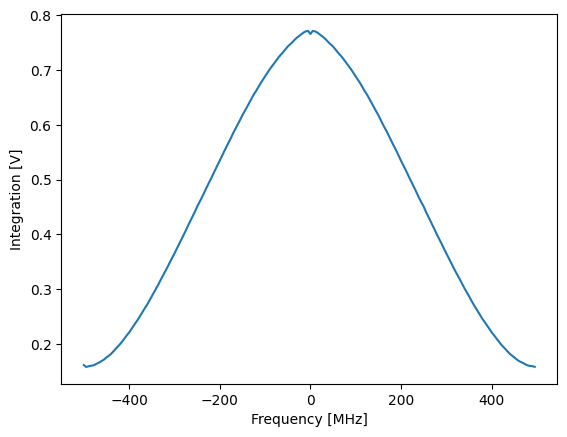

In [14]:
I_data = (
    np.asarray([d["acquisition"]["bins"]["integration"]["path0"][0] for d in data])
    / MAXIMUM_SCOPE_ACQUISITION_LENGTH
)
Q_data = (
    np.asarray([d["acquisition"]["bins"]["integration"]["path1"][0] for d in data])
    / MAXIMUM_SCOPE_ACQUISITION_LENGTH
)
plot_amplitude(nco_sweep_range, I_data, Q_data)

We can see that the output amplitude decreases with frequency, this is expected due to the analog filters. We can also analyze the accumulated scope data with a spectrogram. This takes a few seconds, as there are 16384 data points per frequency step. Note that the time axis of the spectrogram refers to measurement time (16.4us * 200 steps $\approx$ 3.3ms) and not the wall clock time, which is significantly longer.

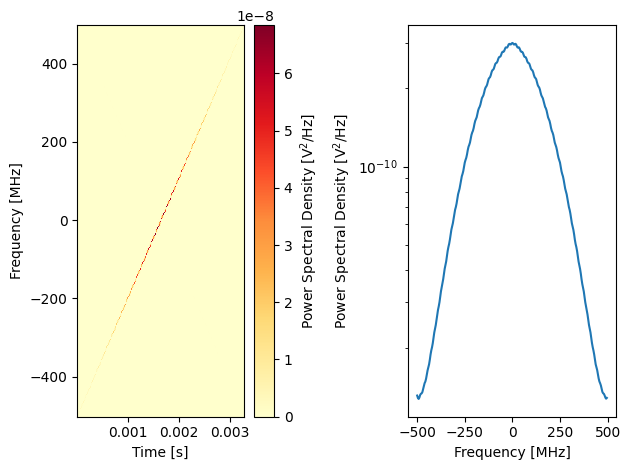

In [15]:
data_scope = (
    np.asarray([d["acquisition"]["scope"]["path0"]["data"] for d in data]).flatten()
    + 1j
    * np.asarray([d["acquisition"]["scope"]["path1"]["data"] for d in data]).flatten()
)

plot_spectrogram(data_scope)

### Spectroscopy using Q1ASM
Now we will run the same spectroscopy experiment using Q1ASM to change the NCO frequency in real time. First, we set up the QRM for continuous wave output and binned acquisition with many bins. This is significantly faster than using QCoDeS. The maximum number of points that can be measured this way is 131072 per sequencer, which is the maximum number of bins.

The sequencer program can fundamentally only support integer values. However, the NCO has a frequency resolution of 0.25 Hz and supports $10^9$ phase values. Therefore, frequencies in the sequencer program must be given as integer multiple of $1/4$ Hz, and phases as integer multiple of $360/10^9$ degree.

In [16]:
n_steps = 200

step_freq = (stop_freq - start_freq) / n_steps
print(f"{n_steps} steps with step size {step_freq/1e6} MHz")

# Convert frequencies to multiples of 0.25 Hz
nco_int_start_freq = int(4 * start_freq)
nco_int_step_freq = int(4 * step_freq)

200 steps with step size 5.0 MHz


In [17]:
acquisitions = {"acq": {"num_bins": n_steps, "index": 0}}

setup = f"""
    move {n_averages}, R2

avg_loop:
    move    0, R0          # frequency
    move    0, R1          # step counter
"""

# To get a negative starting frequency, we substract a positive number from 0
if start_freq <= 0:
    setup += f"""
    sub R0, {-nco_int_start_freq}, R0
    """
else:
    setup += f"""
    add R0, {nco_int_start_freq}, R0
    """

spectroscopy = (
    setup
    + f"""
    reset_ph
    set_freq        R0
    upd_param       200
       
nco_set:
    set_freq        R0                           # Set the frequency
    add             R0, {nco_int_step_freq}, R0  # Update the frequency register
    upd_param       200                          # Wait for time of flight
    acquire         0, R1, {MAXIMUM_SCOPE_ACQUISITION_LENGTH}
    add             R1, 1, R1
    nop
    jlt             R1, {n_steps}, @nco_set      # Loop over all frequencies
    
    loop            R2, @avg_loop
    
    stop                                  # Stop
"""
)

# Add sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": {},
    "weights": {},
    "acquisitions": acquisitions,
    "program": spectroscopy,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)

Now we prepare the QRM for measurement.

In [18]:
qrm.sequencer0.sequence("sequence.json")

In [19]:
%%time
qrm.arm_sequencer(0)
qrm.start_sequencer()

# Wait for the sequencer to stop with a timeout period of one minute.
qrm.get_acquisition_state(0, 1)

data = qrm.get_acquisitions(0)["acq"]

CPU times: total: 156 ms
Wall time: 178 ms


Note that the same measurement as before is now two orders of magnitude faster. If we plot the integrated data, we get the same results as before.

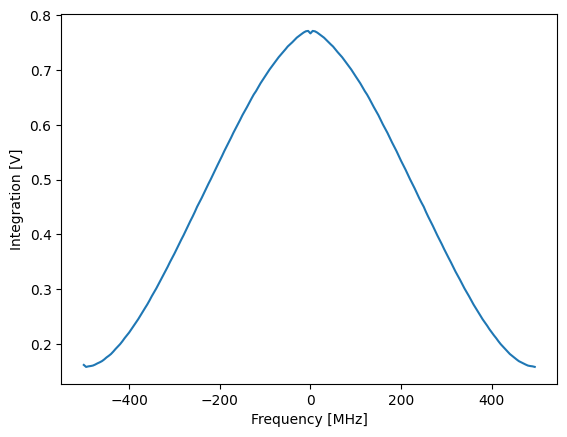

In [20]:
# For plotting, convert the NCO integer values back to frequencies
nco_sweep_range = (np.arange(n_steps)*nco_int_step_freq + nco_int_start_freq) / 4.0

I_data = (
    np.asarray(data["acquisition"]["bins"]["integration"]["path0"])
    / MAXIMUM_SCOPE_ACQUISITION_LENGTH
)
Q_data = (
    np.asarray(data["acquisition"]["bins"]["integration"]["path1"])
    / MAXIMUM_SCOPE_ACQUISITION_LENGTH
)
plot_amplitude(nco_sweep_range, I_data, Q_data)

#### NCO input delay compensation
By default, the input and output of the QRM are multiplied with the same NCO value. As the output path has a time of flight of about 146 ns between the NCO and playback, this means that there is a short time window after frequency/phase updates where demodulation is updated, but playback is still using the old value. There is also always a (fixed) relative phase between playback and demodulation. We can showcase this by using a similar program as before, but with less points, so that the frequency steps are more clearly visible.

In [21]:
n_steps = 20
n_averages = 1000

step_freq = (stop_freq - start_freq) / n_steps
print(f"{n_steps} steps with step size {step_freq/1e6} MHz")

# Convert frequencies to multiples of 0.25 Hz
nco_int_start_freq = int(4 * start_freq)
nco_int_step_freq = int(4 * step_freq)

# For plotting, convert the NCO integer values back to frequencies
nco_sweep_range = np.arange(nco_int_start_freq, 4 * stop_freq, nco_int_step_freq) / 4.0

20 steps with step size 50.0 MHz


To make the effect of NCO delay compensation more apparent, we modify the spectroscopy program for short integration time and acquire immediately after the frequency update, without waiting for time of flight. This means that the output at the new frequency only arrives at the input AFTER integration in the current loop iteration has finished. Without further modifications of the program this leads to an off-by-one error. Therefore, we increase the frequency as the first step in the loop.

In [22]:
acquisitions = {"acq": {"num_bins": n_steps, "index": 0}}

setup = f"""
    move {n_averages}, R2

avg_loop:
    move    0, R0          # frequency
    move    0, R1          # step counter
"""

# To get a negative starting frequency, we substract a positive number from 0
if start_freq <= 0:
    setup += f"""
    sub R0, {-nco_int_start_freq}, R0
    """
else:
    setup += f"""
    add R0, {nco_int_start_freq}, R0
    """

spectroscopy = (
    setup
    + f"""
    reset_ph
    set_freq        R0
    upd_param       200
       
nco_set:
    # Due to time of flight, the new frequency will only arrive at the input AFTER integration is done
    # Therefore, we already increase the frequency before the first measurement.
    add             R0, {nco_int_step_freq}, R0
    nop
    set_freq        R0
    
    # we removed upd_param, so that acquisition starts the moment the frequency is updated
    acquire         0, R1, 1200                  # Update the NCO and immediately acquire
    add             R1, 1, R1
    nop
    jlt             R1, {n_steps}, @nco_set      # Loop over all frequencies
    
    loop            R2, @avg_loop
    
    stop                                  # Stop
"""
)

# Add sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": {},
    "weights": {},
    "acquisitions": acquisitions,
    "program": spectroscopy,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)

As a baseline, we will do a measurement with delay compensation disabled.

In [23]:
qrm.sequencer0.sequence("sequence.json")
qrm.sequencer0.integration_length_acq(140)
qrm.sequencer0.nco_prop_delay_comp_en(False)

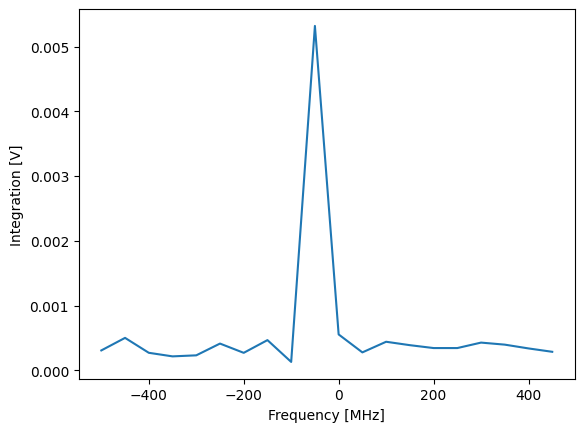

In [24]:
qrm.arm_sequencer(0)
qrm.start_sequencer()

# Wait for the sequencer to stop with a timeout period of one minute.
qrm.get_acquisition_state(0, 1)

data = qrm.get_acquisitions(0)["acq"]
I_data = (
    np.asarray(data["acquisition"]["bins"]["integration"]["path0"])
    / 140
)
Q_data = (
    np.asarray(data["acquisition"]["bins"]["integration"]["path1"])
    / 140
)
plot_amplitude(nco_sweep_range, I_data, Q_data)

Even though we only measured a small number of points, we can see that this is not compatible with the previous spectroscopy measurements. What happened is that `set_freq` updates the NCO frequency immediately. However, there is a time of flight of about 146 ns between the NCO and the output of the device. Thus, the signal will be demodulated at $f_0 + 100$ MHz immediately after `set_freq`, but the incoming signal is still modulated at $f_0$ for another 146 ns - longer than the integration time chosen above. The integrated signal will therefore be approximately zero.

Now we run the same experiment again, with delay compensation enabled.

In [25]:
qrm.sequencer0.sequence("sequence.json")
qrm.sequencer0.nco_prop_delay_comp_en(True)

This ensures that, for demodulation, the NCO only updates after the time of flight, i.e. that frequency and phase of modulation and demodulation always match.

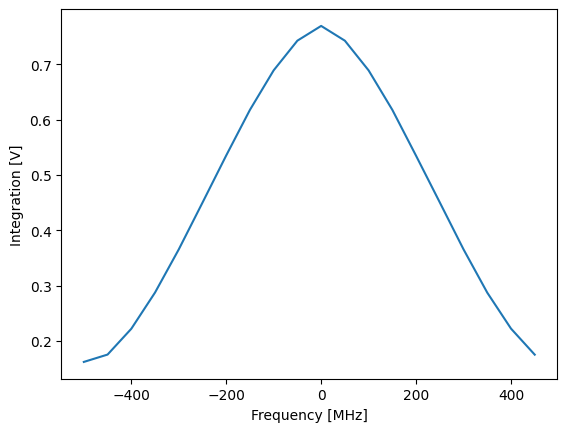

In [26]:
qrm.arm_sequencer(0)
qrm.start_sequencer()

# Wait for the sequencer to stop with a timeout period of one minute.
qrm.get_acquisition_state(0, 1)

data = qrm.get_acquisitions(0)["acq"]
I_data = (
    np.asarray(data["acquisition"]["bins"]["integration"]["path0"])
    / 140
)
Q_data = (
    np.asarray(data["acquisition"]["bins"]["integration"]["path1"])
    / 140
)
amplitude = np.abs(I_data + 1j * Q_data)

plot_amplitude(nco_sweep_range, I_data, Q_data)

We can see that modulation and demodulation frequency now match, producing similar results as the spectroscopy measurements before.

### Fast chirped pulses using Q1ASM
Now we will run a fast frequency sweep using Q1ASM to change the NCO frequency in real time during playback. This type of pulse is also called a chirp. First, we set up the QRM for continuous wave output and a single scope acquisition. This is significantly faster than spectroscopy, but also limits the maximum number of points we can measure in a single program. The total duration of the sweep must be 16384 ns or less, as that is the maximum length of a scope acquisition.

The sequencer program can fundamentally only support integer values. However, the NCO has a frequency resolution of 0.25 Hz and supports $10^9$ phase values. Therefore, frequencies in the sequencer program must be given as an integer multiple of $1/4$ Hz, and phases as an integer multiple of $360/10^9$ degrees.

In [27]:
step_time = 44  # Time per frequency step in ns. We can reduce this, but the program needs to be changed. See next section
n_steps = int(16384 / step_time)
n_averages = 10

step_freq = (stop_freq - start_freq) / n_steps
print(f"{n_steps} steps with step size {step_freq/1e6} MHz")

# Convert frequencies to multiples of 0.25 Hz
nco_int_start_freq = int(4 * start_freq)
nco_int_step_freq = int(4 * step_freq)

# For plotting, convert the NCO integer values back to frequencies
nco_sweep_range = np.arange(nco_int_start_freq, 4 * stop_freq, nco_int_step_freq) / 4.0

372 steps with step size 2.6881720430107525 MHz


Now, we write a Q1ASM program that quickly changes the NCO's frequency, converting the continuous sine output into a chirp. 

Internally, the processor stores negative values using [two's complement](https://en.wikipedia.org/wiki/Two%27s_complement). This has some implications for our program:
- We cannot directly store a negative value in a register. Substracting a larger value from a smaller one works as expected though.
- Immediate values are handled by the compiler, i.e. `set_freq-100` gives the expected result of -25 Hz.
- Comparisons (`jlt, jge`) with registers storing a negative value do not work as expected, as the smallest negative number is **larger** than the largest positive number. To keep the program general we should therefore use `loop` instead.

In [28]:
acquisitions = {"acq": {"num_bins": 1, "index": 0}}

setup = f"""
    move {n_averages}, R2

avg_loop:
    move    0, R0          # frequency
    move {n_steps}, R1     # n_steps
"""

# To get a negative starting frequency, we substract a positive number from 0
if start_freq <= 0:
    setup += f"""
    sub R0, {-nco_int_start_freq}, R0
    """
else:
    setup += f"""
    add R0, {nco_int_start_freq}, R0
    """

# Play a chirped pulse
chirp = (
    setup
    + f"""
    reset_ph
    set_freq 0
    upd_param 200
    acquire 0,0,4                         # Start acquisition. This is not blocking
       
nco_set:
    set_freq        R0                    # Set the frequency
    add             R0,{nco_int_step_freq}, R0  # Update the frequency register
    upd_param       {step_time}
    loop            R1, @nco_set          # Loop over all frequencies
    
    wait            10000
    loop            R2, @avg_loop
    
    stop                                  # Stop
"""
)

# Add sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": {},
    "weights": {},
    "acquisitions": acquisitions,
    "program": chirp,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)

In [29]:
qrm.sequencer0.sequence("sequence.json")
qrm.sequencer0.integration_length_acq(MAXIMUM_SCOPE_ACQUISITION_LENGTH)

Run the program

In [30]:
%%time
qrm.sequencer0.nco_freq(0)
qrm.arm_sequencer(0)
qrm.start_sequencer()

# Wait for the sequencer to stop with a timeout period of one minute.
qrm.get_acquisition_state(0, 1)

# Move acquisition data from temporary memory to acquisition list.
qrm.store_scope_acquisition(0, "acq")
data = qrm.get_acquisitions(0)["acq"]

CPU times: total: 15.6 ms
Wall time: 49.6 ms


Note that this is significantly faster than standard spectroscopy with Q1ASM with a larger number of points. For this measurement, we only use the scope acquisition data. We can analyze it again with a spectrogram.

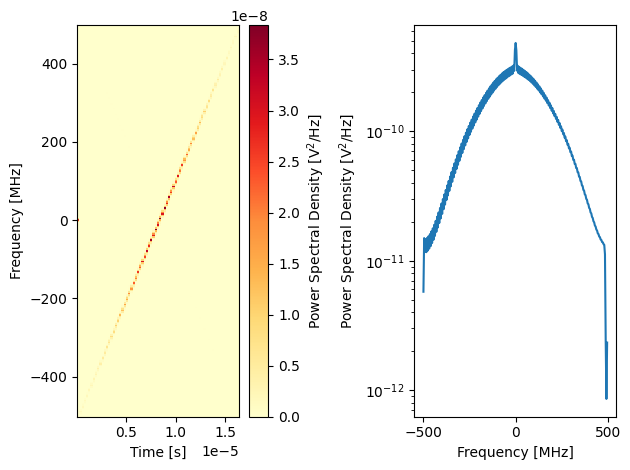

In [31]:
trace = np.array(data["acquisition"]["scope"]["path0"]["data"]) + 1j * np.array(
    data["acquisition"]["scope"]["path1"]["data"]
)
plot_spectrogram(trace)

Note the difference in timescale to before. In the spectrogram we can see the intended spectrum of the chirp.
And finally, we can visualize the chirp pulse. For better clarity, we show the low frequency parts around 8400ns.

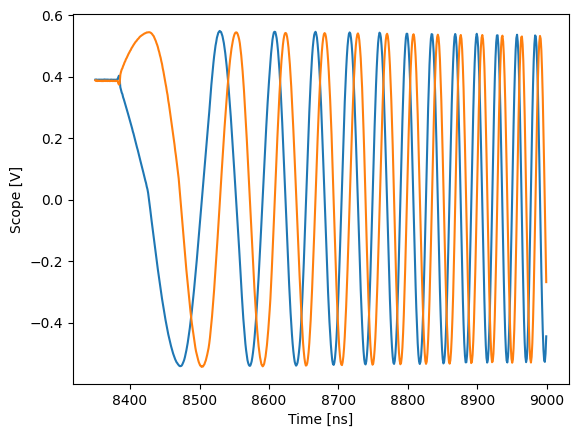

In [32]:
plot_scope(trace, 8350, 9000)

#### Timings of the Q1 and realtime processors
The sequencer has a real-time pipeline that generates the output and a classical pipeline responsible for logic and filling the queue of the real-time pipeline. This queue is 32 instructions long and starts pre-filled when the sequencer is started. If the runtime of classical instructions is shorter than the corresponding real-time instructions, the sequencer will stop. See also in the documentation of the [sequencer](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/documentation/sequencer.html#program).

We can see this by running the same program as before, but with reduced time between frequency steps:

In [33]:
step_time = 40  # this will cause stalling

n_steps = int(16384 / step_time)
step_freq = (stop_freq - start_freq) / n_steps
print(f"{n_steps} steps with step size {step_freq/1e6} MHz")

# Convert frequencies to multiples of 0.25 Hz
nco_int_start_freq = int(4 * start_freq)
nco_int_step_freq = int(4 * step_freq)

# For plotting, convert the NCO integer values back to frequencies
nco_sweep_range = np.arange(nco_int_start_freq, 4 * stop_freq, nco_int_step_freq) / 4.0

409 steps with step size 2.4449877750611244 MHz


In [34]:
acquisitions = {"acq": {"num_bins": 1, "index": 0}}

setup = f"""
    move {n_averages}, R2

avg_loop:
    move {n_steps}, R1  # n_steps
    move    0, R0          # frequency
    nop
"""

# To get a negative starting frequency, we substract a positive number from 0
if start_freq <= 0:
    setup += f"""
    sub R0, {-nco_int_start_freq}, R0
    """
else:
    setup += f"""
    add R0, {nco_int_start_freq}, R0
    """

# Play a chirped pulse
chirp = (
    setup
    + f"""
    reset_ph
    set_freq 0
    upd_param 200
    acquire 0,0,4                         # Start acquisition. This is not blocking
       
nco_set:
    set_freq        R0                    # Set the frequency
    add             R0,{nco_int_step_freq}, R0  # Update the frequency register
    upd_param       {step_time}
    loop            R1, @nco_set          # Loop over all frequencies
    
    wait            10000
    loop            R2, @avg_loop
    
    stop                                  # Stop
"""
)

# Add sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": {},
    "weights": {},
    "acquisitions": acquisitions,
    "program": chirp,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

In [35]:
qrm.sequencer0.sequence("sequence.json")

qrm.arm_sequencer(0)
qrm.start_sequencer()

# Wait for the sequencer to stop with a timeout period of one minute.
qrm.get_acquisition_state(0, 1)

# Move acquisition data from temporary memory to acquisition list.
qrm.store_scope_acquisition(0, "acq")
data = qrm.get_acquisitions(0)["acq"]

As can be seen from the red LEDs on the front of your Cluster/Pulsar, the Q1 processor has stalled, and the program stopped.

In [36]:
print(qrm.sequencer0.get_sequencer_state())

Status: STOPPED, Flags: FORCED_STOP, SEQUENCE_PROCESSOR_RT_EXEC_COMMAND_UNDERFLOW, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


We can also see on the scope that the chirp has been stopped prematurely.

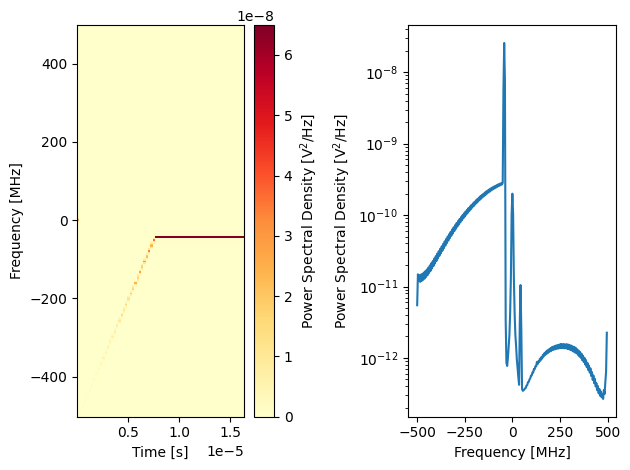

In [37]:
trace = np.array(data["acquisition"]["scope"][f"path0"]["data"]) + 1j * np.array(
    data["acquisition"]["scope"][f"path1"]["data"]
)
plot_spectrogram(trace)

Before continuing, we clear the flags on the qrm:

In [38]:
if 'pulsar' in device_name:
    qrm.clear()
else:
    cluster.clear()


If we want to the chirp to use as many updates as possible, we need to unroll the loop. This way, we can reduce the time per frequency step down to 24ns: `set_freq, upd_param` both take 4ns and `add` takes 12ns on the Q1 processor for a total of 20ns per frequency step.

In [39]:
step_time = 20

n_steps = int(16384 / step_time)
step_freq = (stop_freq - start_freq) / n_steps
print(f"{n_steps} steps with step size {step_freq/1e6} MHz")

# Convert frequencies to multiples of 0.25 Hz
nco_int_start_freq = int(4 * start_freq)
nco_int_step_freq = int(4 * step_freq)

# For plotting, convert the NCO integer values back to frequencies
nco_sweep_range = np.arange(nco_int_start_freq, 4 * stop_freq, nco_int_step_freq) / 4.0

819 steps with step size 1.221001221001221 MHz


This does not leave room for a loop, which would take an additional 24ns. However, we can use the instruction memory of the Q1 processor:

In [40]:
chirp = f"""
    move {n_averages}, R2

avg_loop:
    move    0, R0          # frequency
    nop
"""

# To get a negative starting frequency, we substract a positive number from 0
if start_freq <= 0:
    chirp += f"""
    sub R0, {-nco_int_start_freq}, R0
    """
else:
    chirp += f"""
    add R0, {nco_int_start_freq}, R0
    """

chirp += f"""
    reset_ph
    set_freq 0
    upd_param 200
    acquire 0,0,4                         # Start acquisition. This is not blocking
       
"""
# unroll the loop into individual commands
for _ in range(n_steps):
    chirp += f"""
    set_freq        R0                    # Set the frequency
    add             R0,{nco_int_step_freq}, R0  # Update the frequency register
    upd_param       {step_time}
"""
chirp += """
    
    wait            10000
    loop            R2, @avg_loop
    
    stop                                  # Stop
"""
# Add sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": {},
    "weights": {},
    "acquisitions": acquisitions,
    "program": chirp,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

In [41]:
qrm.sequencer0.sequence("sequence.json")

Now we execute the program and plot the spectrogram:

In [42]:
%%time
qrm.arm_sequencer(0)
qrm.start_sequencer()

# Wait for the sequencer to stop with a timeout period of one minute.
qrm.get_acquisition_state(0, 1)

# Move acquisition data from temporary memory to acquisition list.
qrm.store_scope_acquisition(0, "acq")
data = qrm.get_acquisitions(0)["acq"]

CPU times: total: 15.6 ms
Wall time: 45.1 ms


Note that the execution time is comparable to the other chirped measurements, but with more than double the number of points.

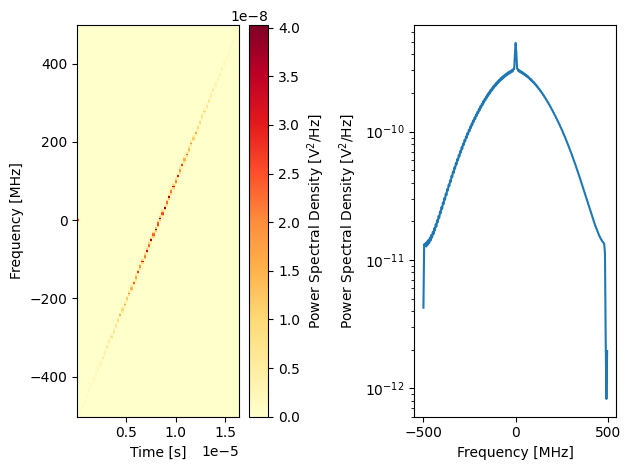

In [43]:
trace = np.array(data["acquisition"]["scope"][f"path0"]["data"]) + 1j * np.array(
    data["acquisition"]["scope"][f"path1"]["data"]
)
plot_spectrogram(trace)

## Phase updates
### Virtual Z gates
In addition to fast frequency updates, the sequencer also supports real-time changes of the NCO phase. In particular for superconducting qubits, this can be used for a so-called virtual $Z$ gate, see [McKay et al. (2016)](https://arxiv.org/abs/1612.00858).
The virtual $Z$ gate is a change of reference frame rather than a physical operation. Therefore, it is instantaneous and near perfect - the dominant error being that the NCO has a finite resolution of $10^9$ different phases. Below, we will demonstrate how to to use a virtual Z to use the same pulse for both $X$ and $Y$ rotations.

As the sequencer internally only supports integer values, we must first convert the phase into an integer multiple of $360/10^{9}$ degree:

In [44]:
int_90 = int(90 * (1e9 / 360))
int_270 = int(270 * (1e9 / 360))

In [45]:
# Waveforms
waveform_len = 1000
waveforms = {
    "gaussian": {
        "data": gaussian(waveform_len, std=0.133 * waveform_len).tolist(),
        "index": 0,
    },
}

# Acquisitions
acquisitions = {"scope": {"num_bins": 1, "index": 0}}

# Program
virtual_z = f"""
acquire         0,0,4                 
play            0,0,{waveform_len}      # X90

# This is equivalent to Y90, but uses the same waveform as X90
reset_ph
set_ph_delta    {int_90}     # Z90
play            0,0,{waveform_len}      # X90
set_ph_delta    {int_270}    # Z-90

stop
"""

# Write sequence to file.
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(
        {
            "waveforms": waveforms,
            "weights": {},
            "acquisitions": acquisitions,
            "program": virtual_z,
        },
        file,
        indent=4,
    )
    file.close()

For this experiment, we reset the QRM and enable modulation at a low frequency so that the effects are easily visible (without offsets).

In [46]:
# Program sequencers.
if 'pulsar' in device_name:
    qrm.reset()
else:
    cluster.reset()

qrm.sequencer0.sequence("sequence.json")

# Configure sequencer
qrm.sequencer0.channel_map_path0_out0_en(True)
qrm.sequencer0.channel_map_path1_out1_en(True)
qrm.sequencer0.nco_freq(3e6)

# Enable modulation
qrm.sequencer0.mod_en_awg(True)
qrm.sequencer0.demod_en_acq(True)

# Enable hardware averaging for the scope
qrm.scope_acq_avg_mode_en_path0(True)
qrm.scope_acq_avg_mode_en_path1(True)

qrm.sequencer0.integration_length_acq(MAXIMUM_SCOPE_ACQUISITION_LENGTH)

Now we can run the program and look at the scope acquisition.

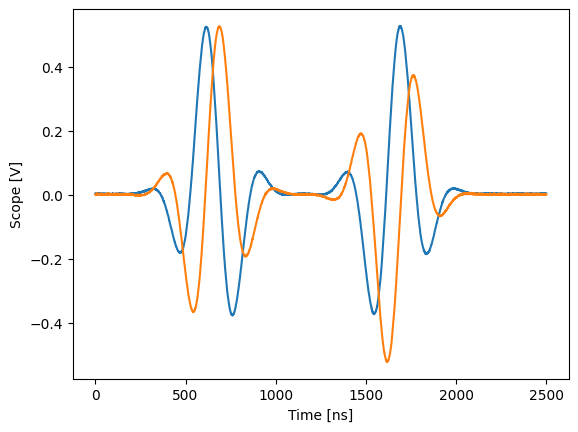

In [47]:
# Start the sequence
qrm.arm_sequencer(0)
qrm.start_sequencer()

# Wait for the sequencer to stop
qrm.get_acquisition_state(0, 1)

# Get acquisition data
qrm.store_scope_acquisition(0, "scope")
acq = qrm.get_acquisitions(0)

trace = np.asarray(
    acq["scope"]["acquisition"]["scope"]["path0"]["data"]
) + 1j * np.asarray(acq["scope"]["acquisition"]["scope"]["path1"]["data"])

plot_scope(trace, 0, 2500)

### Chirped pulses using the phase update
As an exercise combining the concepts from this notebook, we can also create a chirp using only phase updates. This is purely educational and should not be used in an experiment. Again, we do not use a loop, and use the instruction memory instead to make the step size smaller.

In [48]:
n_averages = 100
n_steps = int(16384 / (20))

acquisitions = {"acq": {"num_bins": 1, "index": 0}}


phase_chirp = f"""
    move {n_averages}, R2

avg_loop:
    move    0, R0                         # phase update step size
    reset_ph
    set_freq 0
    upd_param 200
    acquire 0,0,4                         # Start acquisition. This is not blocking
       
nco_set:
"""
# step the phase with increasing step size
for _ in range(n_steps):
    phase_chirp += f"""
    set_ph_delta    R0
    upd_param       20
    add             R0, {int(1e9/(4*n_steps))}, R0      # increase the 'frequency'
"""
phase_chirp += """
    wait            10000
    loop            R2, @avg_loop
    
    stop                                  # Stop
"""

# Write sequence to file.
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(
        {
            "waveforms": waveforms,
            "weights": {},
            "acquisitions": acquisitions,
            "program": phase_chirp,
        },
        file,
        indent=4,
    )
    file.close()

We can run this with the same settings as the chirps before:

In [49]:
qrm.sequencer0.sequence("sequence.json")

# Set DC Offset
qrm.sequencer0.offset_awg_path0(1)
qrm.sequencer0.offset_awg_path1(1)

qrm.arm_sequencer(0)
qrm.start_sequencer()

# Wait for the sequencer to stop with a timeout period of one minute.
qrm.get_acquisition_state(0, 1)

# Move acquisition data from temporary memory to acquisition list.
qrm.store_scope_acquisition(0, "acq")
data = qrm.get_acquisitions(0)["acq"]

In the spectrogram we can see a slow frequency sweep - plus high frequency components. The reason for those is easily visible in the scope, the "sine" wave is not smooth, but instead made up of many square pulses (as expected).

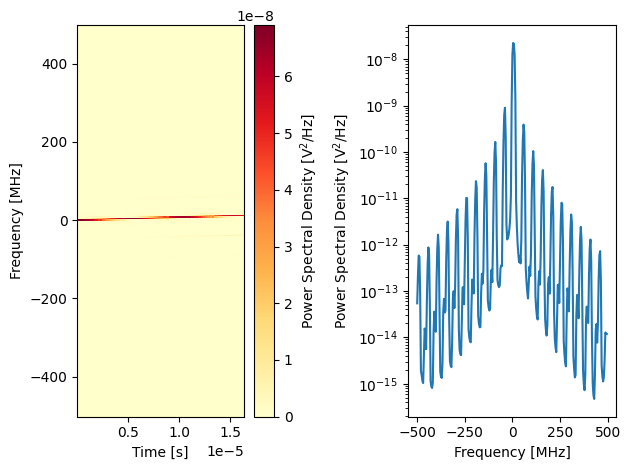

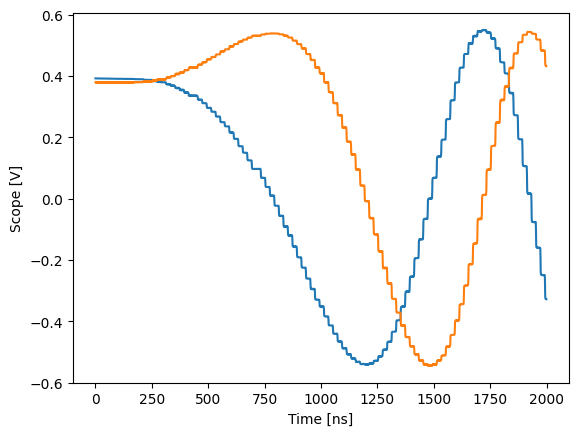

In [50]:
trace = np.array(data["acquisition"]["scope"]["path0"]["data"]) + 1j * np.array(
    data["acquisition"]["scope"]["path1"]["data"]
)
plot_spectrogram(trace)

plot_scope(trace, 0, 2000)

Using registers, we can also do negative phase steps:

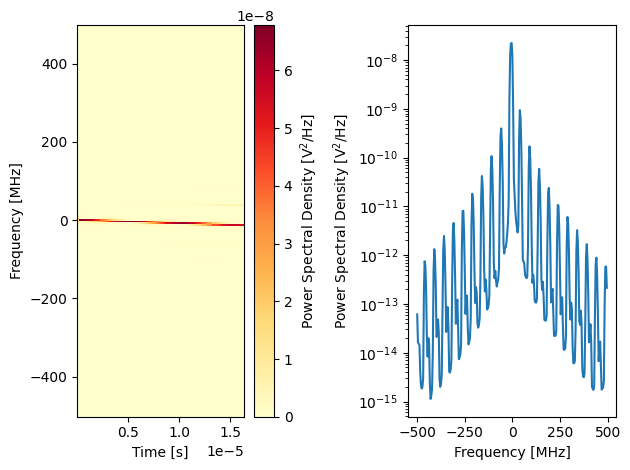

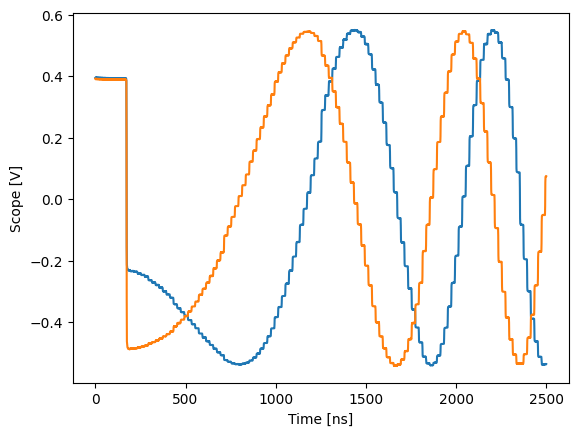

In [51]:
n_averages = 100
n_steps = int(16384 / (20))

acquisitions = {"acq": {"num_bins": 1, "index": 0}}


phase_chirp = f"""
    move {n_averages}, R2

avg_loop:
    move    0, R0                         # phase update step size
    reset_ph
    upd_param 200
    set_freq 0
    acquire 0,0,4                         # Start acquisition. This is not blocking
       
nco_set:
"""
# step the phase with increasing (negative) step size
for _ in range(n_steps):
    phase_chirp += f"""
    set_ph_delta    R0
    upd_param       20
    sub             R0, {int(1e9/(4*n_steps))}, R0      # increase the step size ('frequency')
"""
phase_chirp += """
    wait            10000
    loop            R2, @avg_loop
    
    stop                                  # Stop
"""

# Write sequence to file.
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(
        {
            "waveforms": waveforms,
            "weights": {},
            "acquisitions": acquisitions,
            "program": phase_chirp,
        },
        file,
        indent=4,
    )
    file.close()

qrm.sequencer0.sequence("sequence.json")

qrm.arm_sequencer(0)
qrm.start_sequencer()

# Wait for the sequencer to stop with a timeout period of one minute.
qrm.get_acquisition_state(0, 1)

# Move acquisition data from temporary memory to acquisition list.
qrm.store_scope_acquisition(0, "acq")
data = qrm.get_acquisitions(0)["acq"]

trace = np.array(data["acquisition"]["scope"]["path0"]["data"]) + 1j * np.array(
    data["acquisition"]["scope"]["path1"]["data"]
)
plot_spectrogram(trace)

plot_scope(trace, 0, 2500)

## Stop

Finally, let's stop the playback and close the instrument connection. One can also display a detailed snapshot containing the instrument parameters before 
closing the connection by uncommenting the corresponding lines. 

In [52]:
# Stop both sequencers.
qrm.stop_sequencer()

# Print status of both sequencers (should now say it is stopped).
print(qrm.get_sequencer_state(0))
print(qrm.get_sequencer_state(1))
print()

# Uncomment the following to print an overview of the instrument parameters.
# Print an overview of the instrument parameters.
# print("Snapshot:")
# qxm.print_readable_snapshot(update=True)

# Close the instrument connection.
Pulsar.close_all()
Cluster.close_all()

Status: STOPPED, Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_OVERWRITTEN_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_SCOPE_OVERWRITTEN_PATH_1, ACQ_BINNING_DONE
Status: STOPPED, Flags: FORCED_STOP

